In [2]:
import arviz
import matplotlib.pyplot as plt
import pandas as pd
from utils.model import PresidentialElectionsModel
from utils.posteriorplots import predictive_plot, retrodictive_plot

In [3]:
arviz.style.use("arviz-darkgrid")
arviz.rcParams["plot.max_subplots"] = 50

In [4]:
%load_ext autoreload
%autoreload 2

## Model with socio-eco predictors

In [7]:
for i in [8, 6, 4, 2, None]:
    if i:
        TEST_CUTOFF = pd.Timedelta(i, "W")
    else:
        TEST_CUTOFF = None
    print(f"{TEST_CUTOFF = }\n")

    election_date = "2017-04-23"
    mb = PresidentialElectionsModel(
        election_date=election_date,
        test_cutoff=TEST_CUTOFF,
        weights=[0.1, 0.4, 0.5],  # [0.1, 0.3, 0.6], [0.2, 0.5, 0.3],
        timescales=[5, 14, 28],
    )
    hierarchical_dm = mb.build_model()

    idata_hierarchical_dm = mb.sample_all(
        var_names=[
            "latent_popularity",
            "latent_pop_t0",
            "R",
            "noisy_popularity",
            "N_approve",
        ],
    )

    polls_train = mb.polls_train.copy()
    retrodictive_plot(
        idata_hierarchical_dm.sel(
            elections="2002-04-21",
            observations=polls_train[polls_train.dateelection == "2002-04-21"].index,
        ),
        mb.political_families,
        polls_train[polls_train.dateelection == "2002-04-21"],
        group="prior",
    )

    election_forecast = mb.forecast_election(idata_hierarchical_dm)

    results = mb.results_raw.copy()
    polls_test = mb.polls_test.copy()
    predictive_plot(
        election_forecast,
        mb.political_families,
        election_date,
        results[results.dateelection == election_date],
        polls_train[polls_train.dateelection == election_date],
        polls_test[polls_test.dateelection == election_date],
        TEST_CUTOFF,
    )
    if i:
        plt.savefig(f"ppc_{i}_weeks.png")
    else:
        plt.savefig("ppc_2_days.png")

TEST_CUTOFF = Timedelta('56 days 00:00:00')



/home/remi/.virtualenvs/2022/lib/python3.9/site-packages/pandas/core/algorithms.py:431: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  uniques = table.unique(values)
/home/remi/.virtualenvs/2022/lib/python3.9/site-packages/pandas/core/indexes/base.py:2023: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.is_unique
/home/remi/.virtualenvs/2022/lib/python3.9/site-packages/pandas/core/indexes/base.py:3512: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comp

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2530 seconds.


0, dim: observations, 472 =? 472
1, dim: parties_complete, 1 =? 8
0, dim: elections_observed, 4 =? 4
1, dim: parties_complete, 1 =? 8


The number of effective samples is smaller than 25% for some parameters.


0, dim: observations, 472 =? 472
1, dim: parties_complete, 1 =? 8
0, dim: elections_observed, 4 =? 4
1, dim: parties_complete, 1 =? 8


AttributeError: 'PresidentialElectionsModel' object has no attribute 'parties_complete'

In [8]:
summary = arviz.summary(idata_hierarchical_dm, round_to=2)
low_ess = summary[(summary.ess_bulk <= 1000) | (summary.ess_tail <= 1000)]

In [13]:
summary[(summary.ess_bulk <= 400) | (summary.ess_tail <= 400)]

Empty DataFrame
Columns: [mean, sd, hdi_3%, hdi_97%, mcse_mean, mcse_sd, ess_bulk, ess_tail, r_hat]
Index: []

In [14]:
low_ess[
    (~low_ess.index.str.startswith("noisy"))
    & (~low_ess.index.str.startswith("latent"))
    & (~low_ess.index.str.startswith("election_party_time_effect"))
]

Empty DataFrame
Columns: [mean, sd, hdi_3%, hdi_97%, mcse_mean, mcse_sd, ess_bulk, ess_tail, r_hat]
Index: []

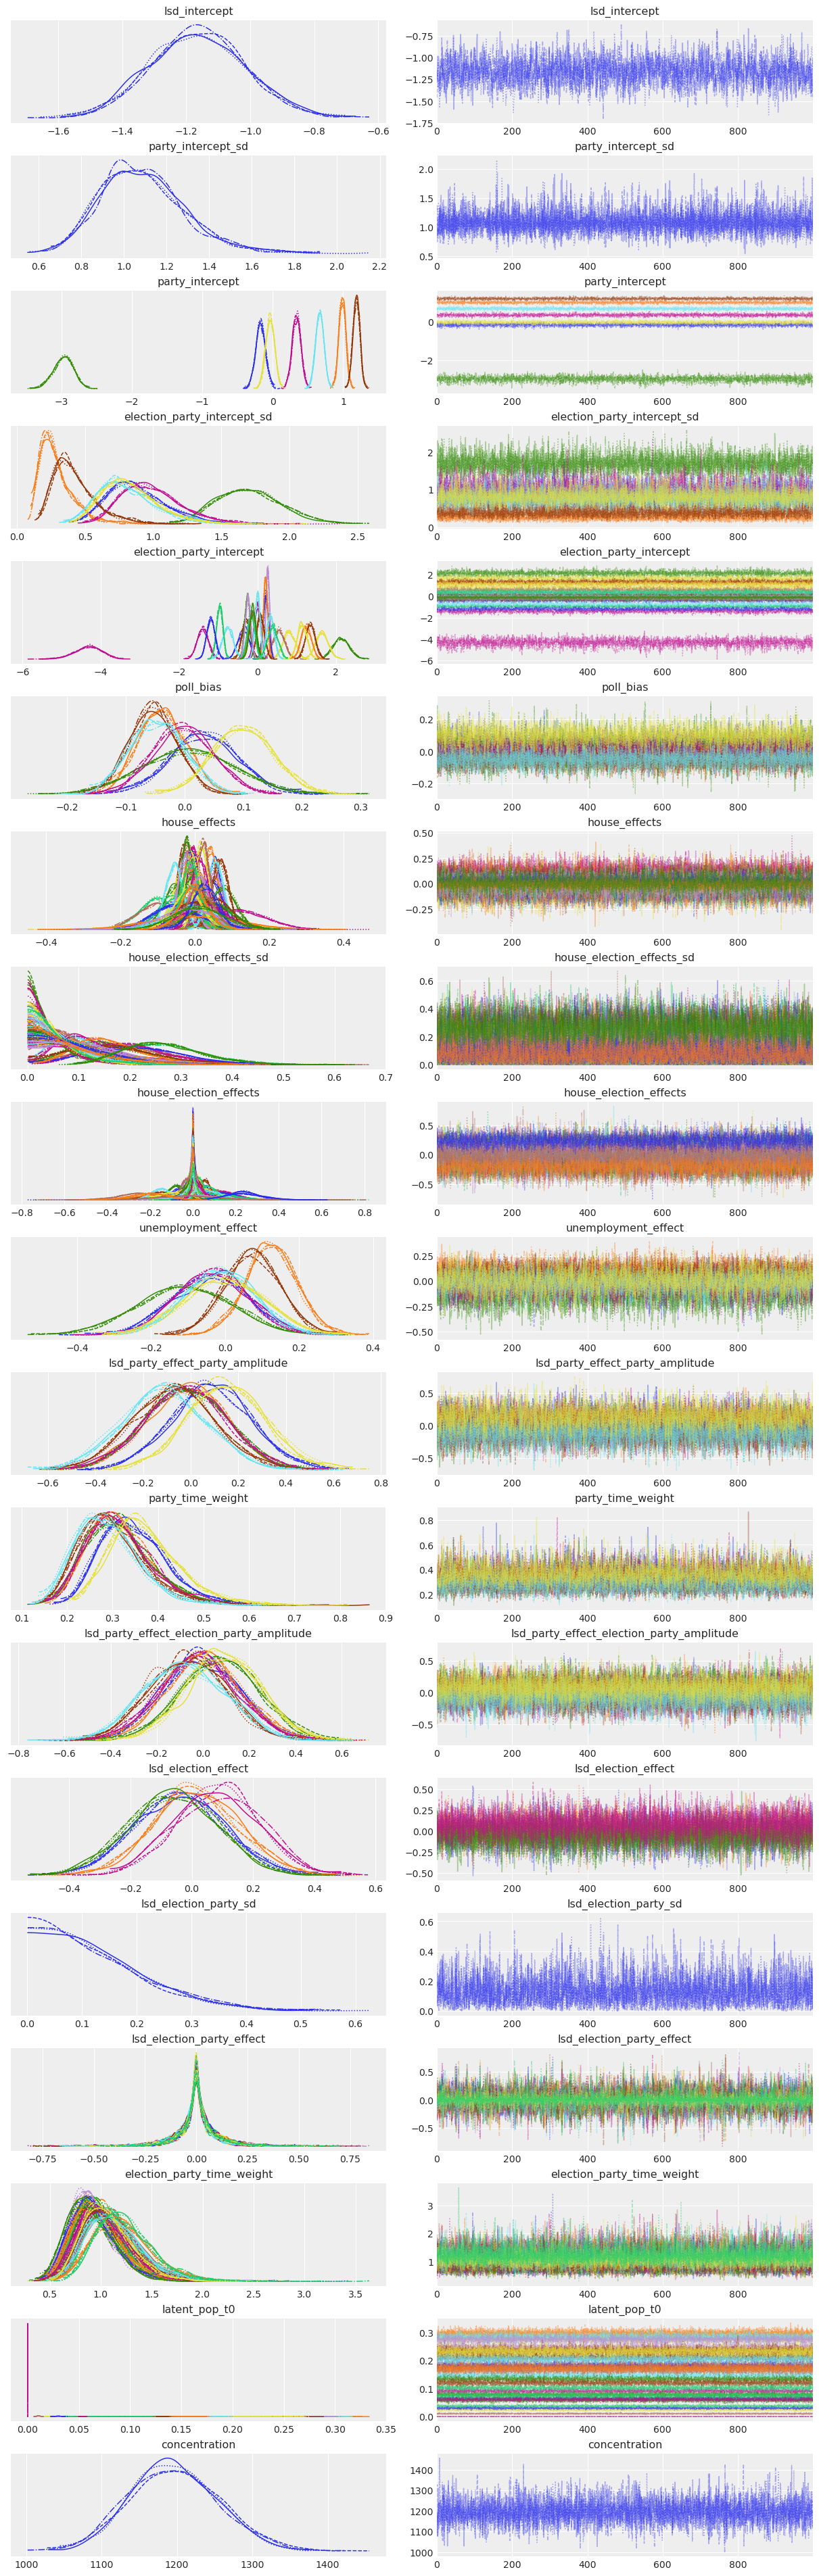

In [15]:
arviz.plot_trace(
    idata_hierarchical_dm,
    var_names=[
        "~time_effect",
        "~time_coefs",
        "~latent_popularity",
        "~noisy_popularity",
        "~raw",
    ],
    filter_vars="regex",
);

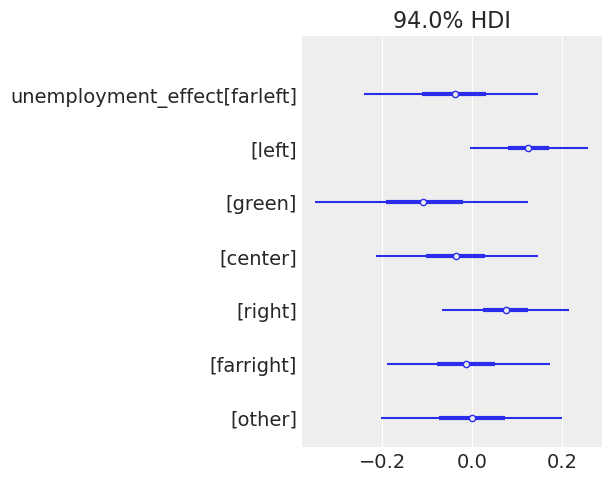

In [16]:
arviz.plot_forest(election_forecast, var_names="unemployment_effect", combined=True);

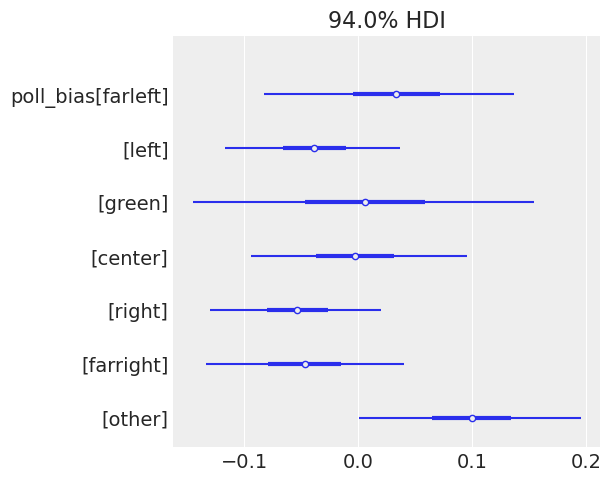

In [17]:
arviz.plot_forest(election_forecast, var_names="poll_bias", combined=True);

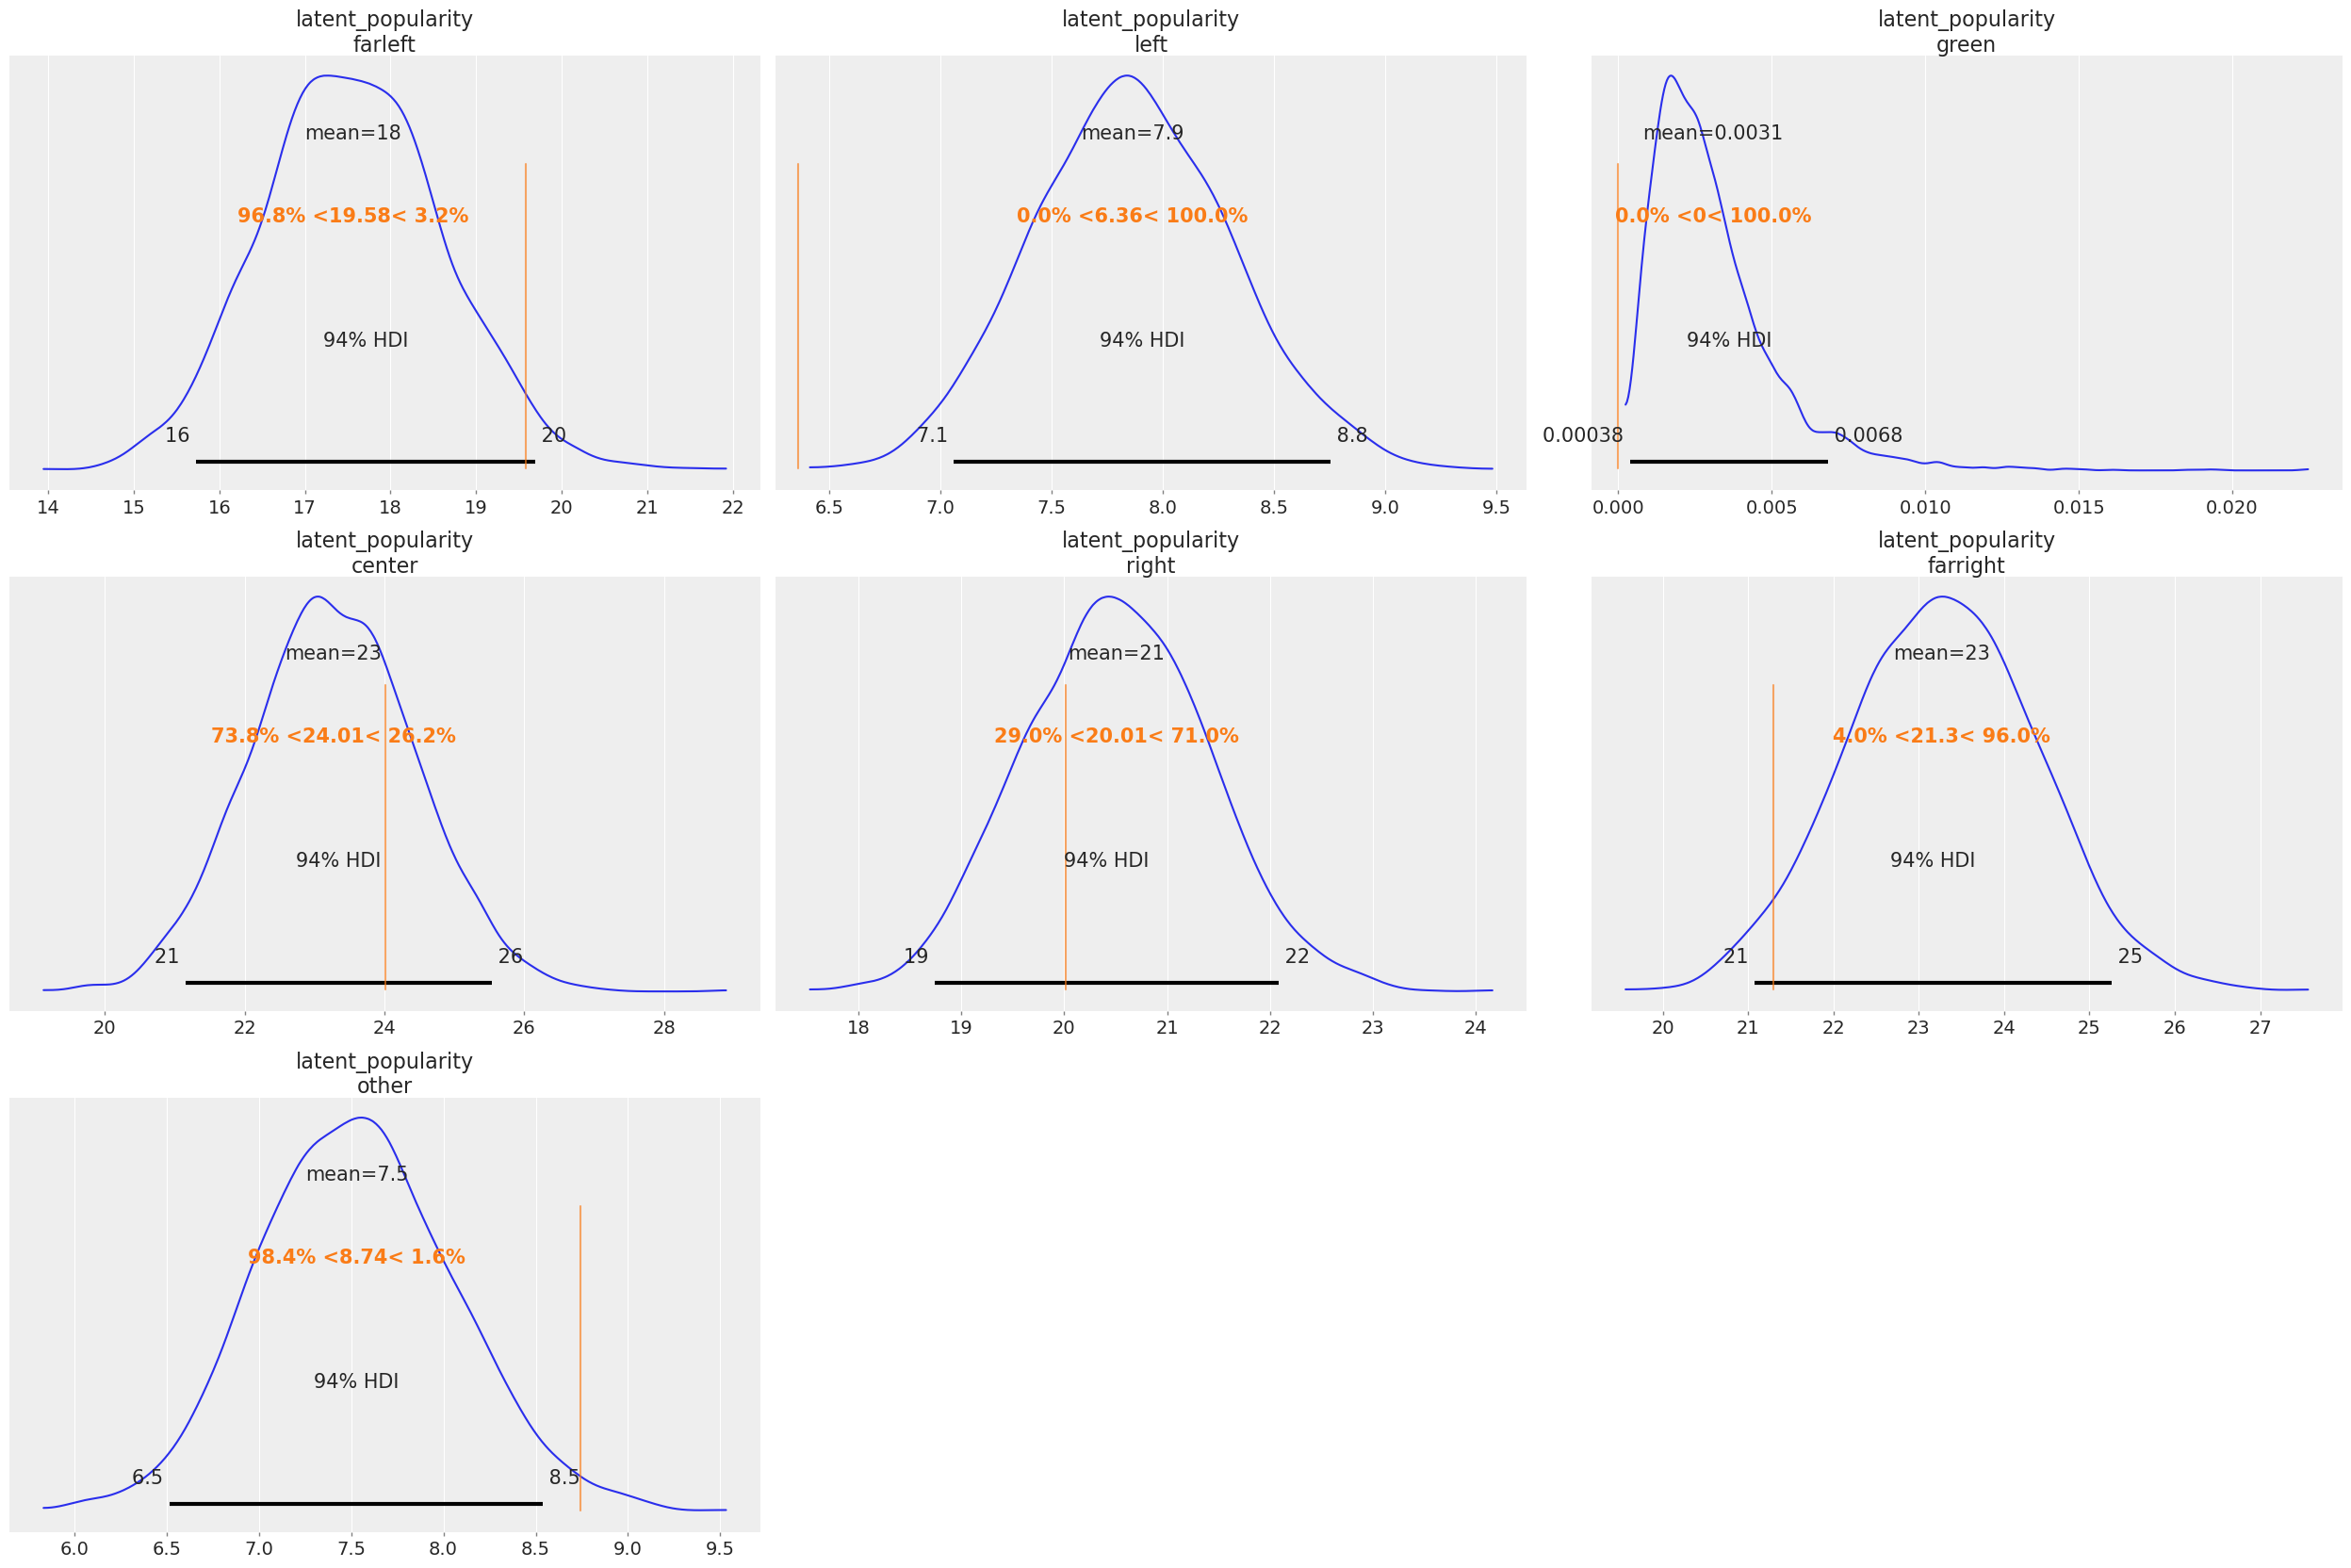

In [18]:
arviz.plot_posterior(
    election_forecast.predictions["latent_popularity"].sel(observations="2017-04-23")
    * 100,
    ref_val=results[mb.political_families].iloc[-1].to_list(),
);

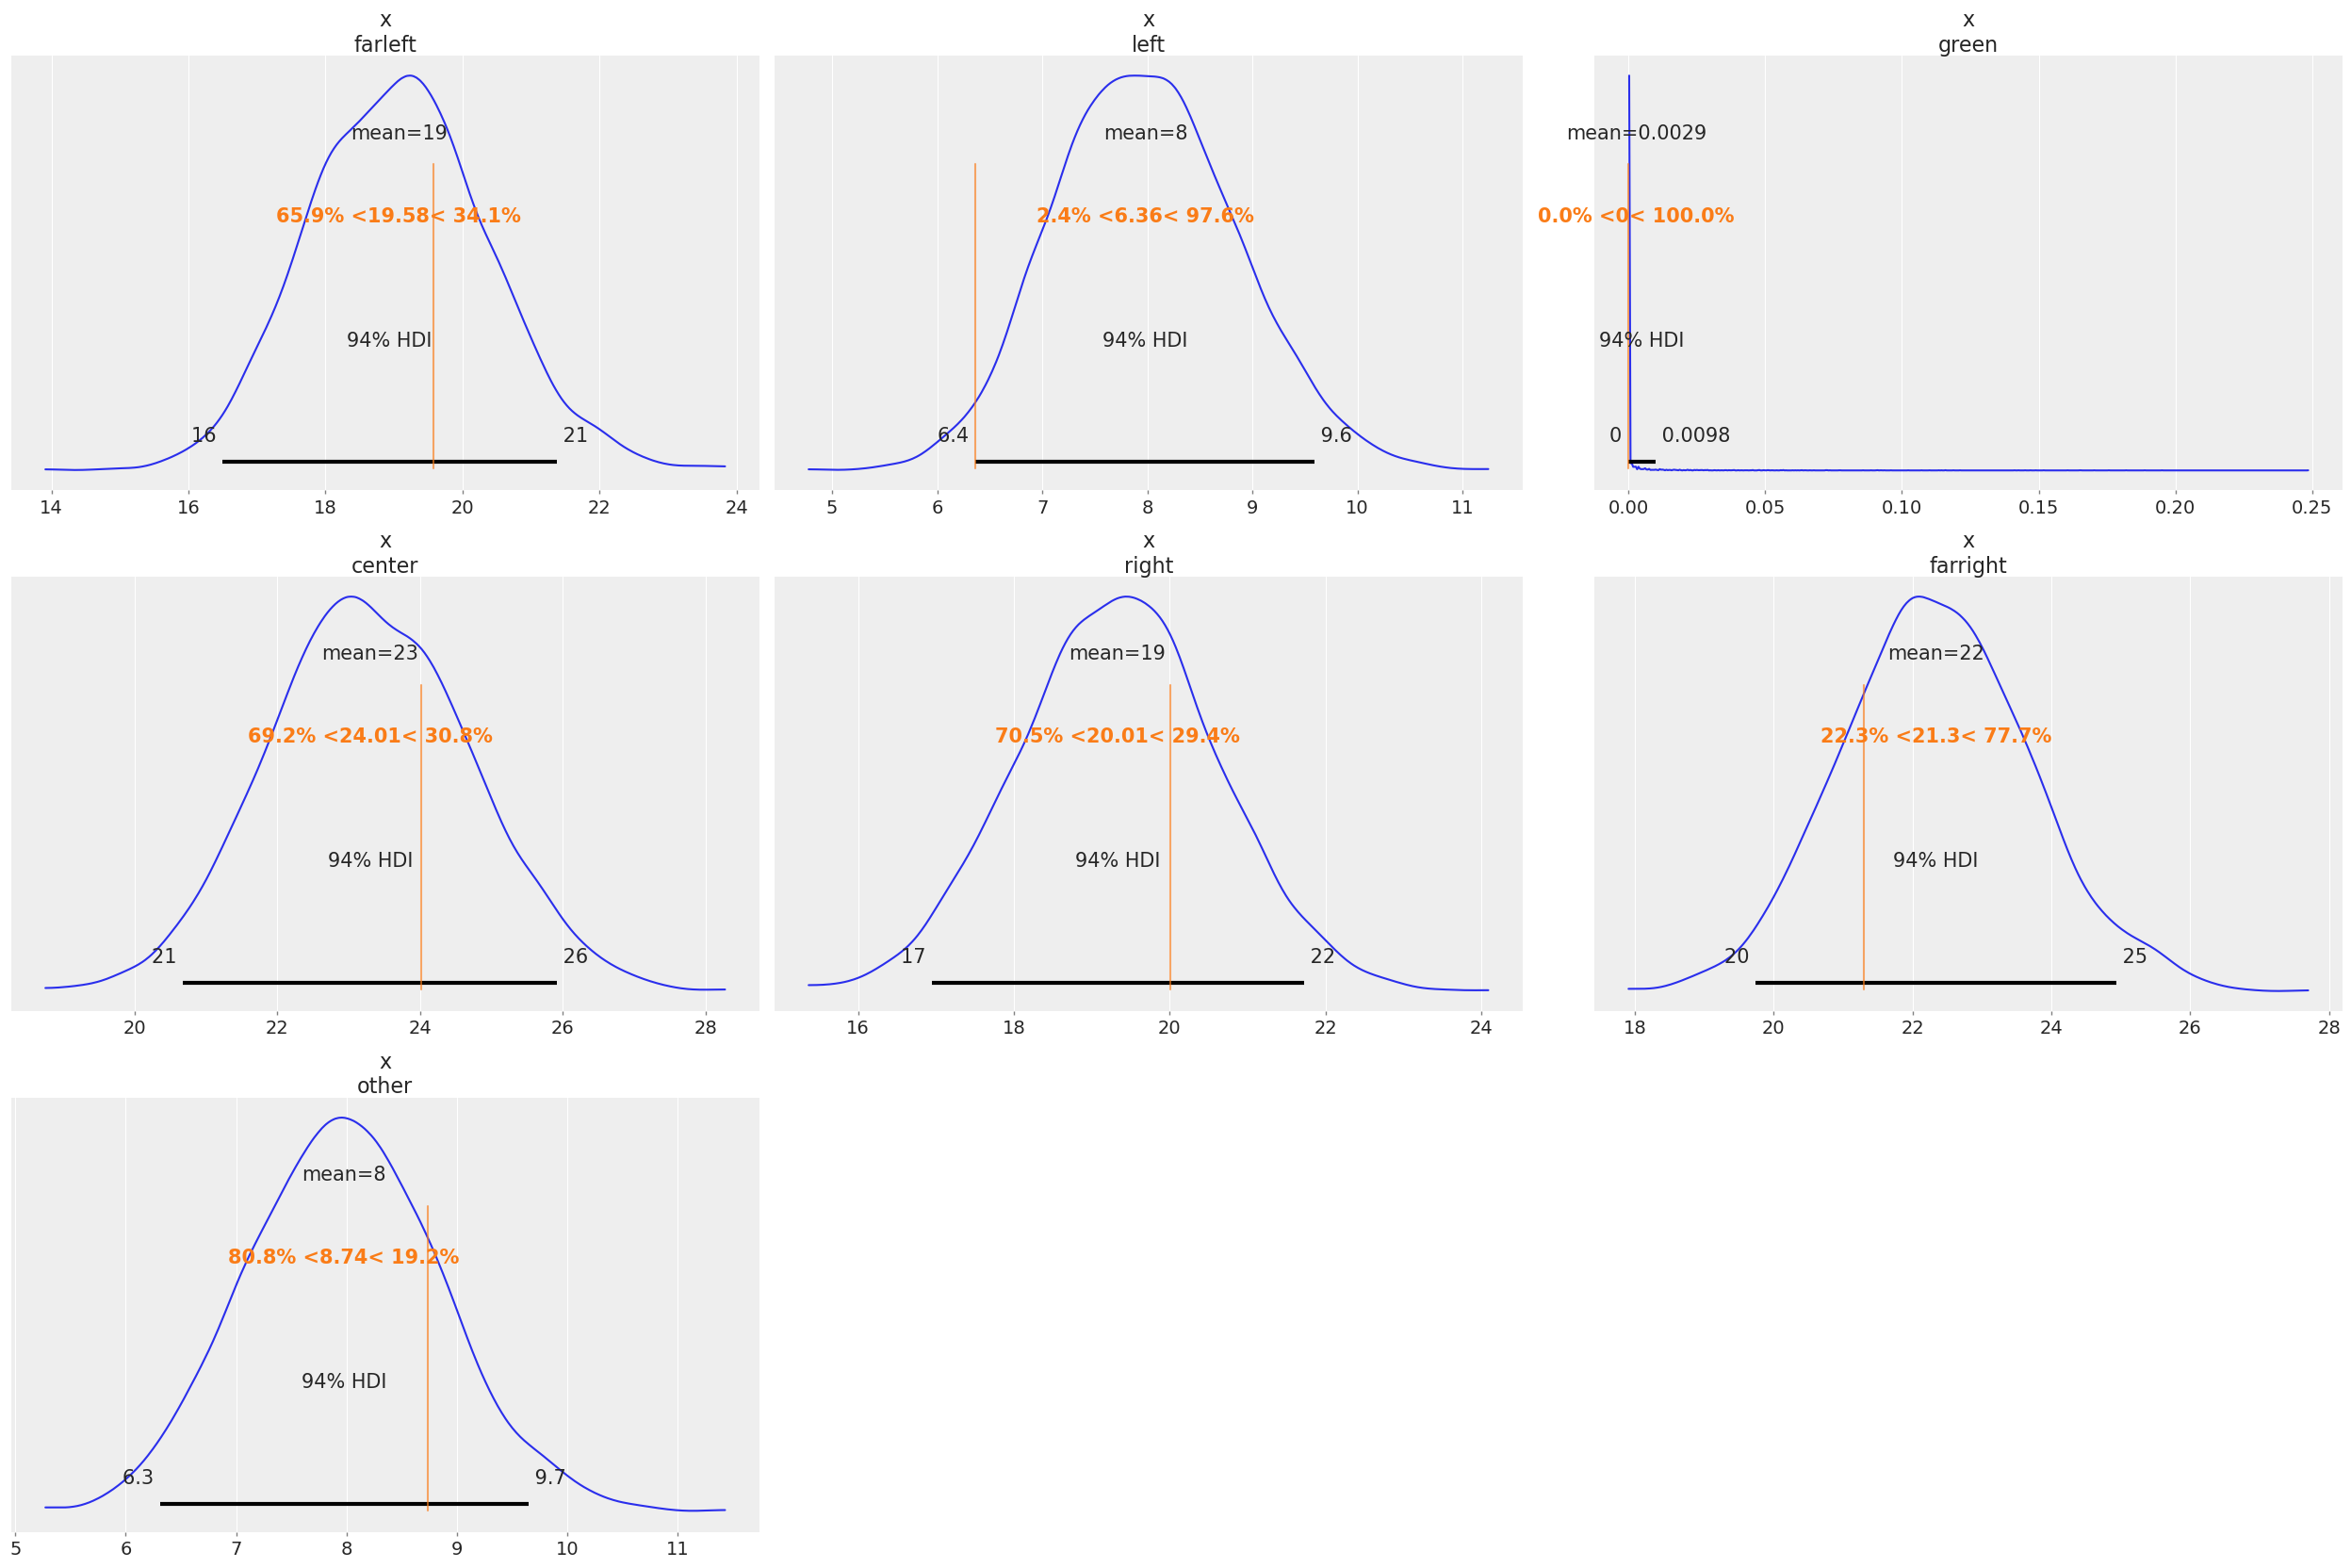

In [19]:
arviz.plot_posterior(
    (
        election_forecast.predictions["N_approve"]
        / election_forecast.predictions_constant_data["observed_N"]
    ).sel(observations="2017-04-23")
    * 100,
    ref_val=results[mb.political_families].iloc[-1].to_list(),
);

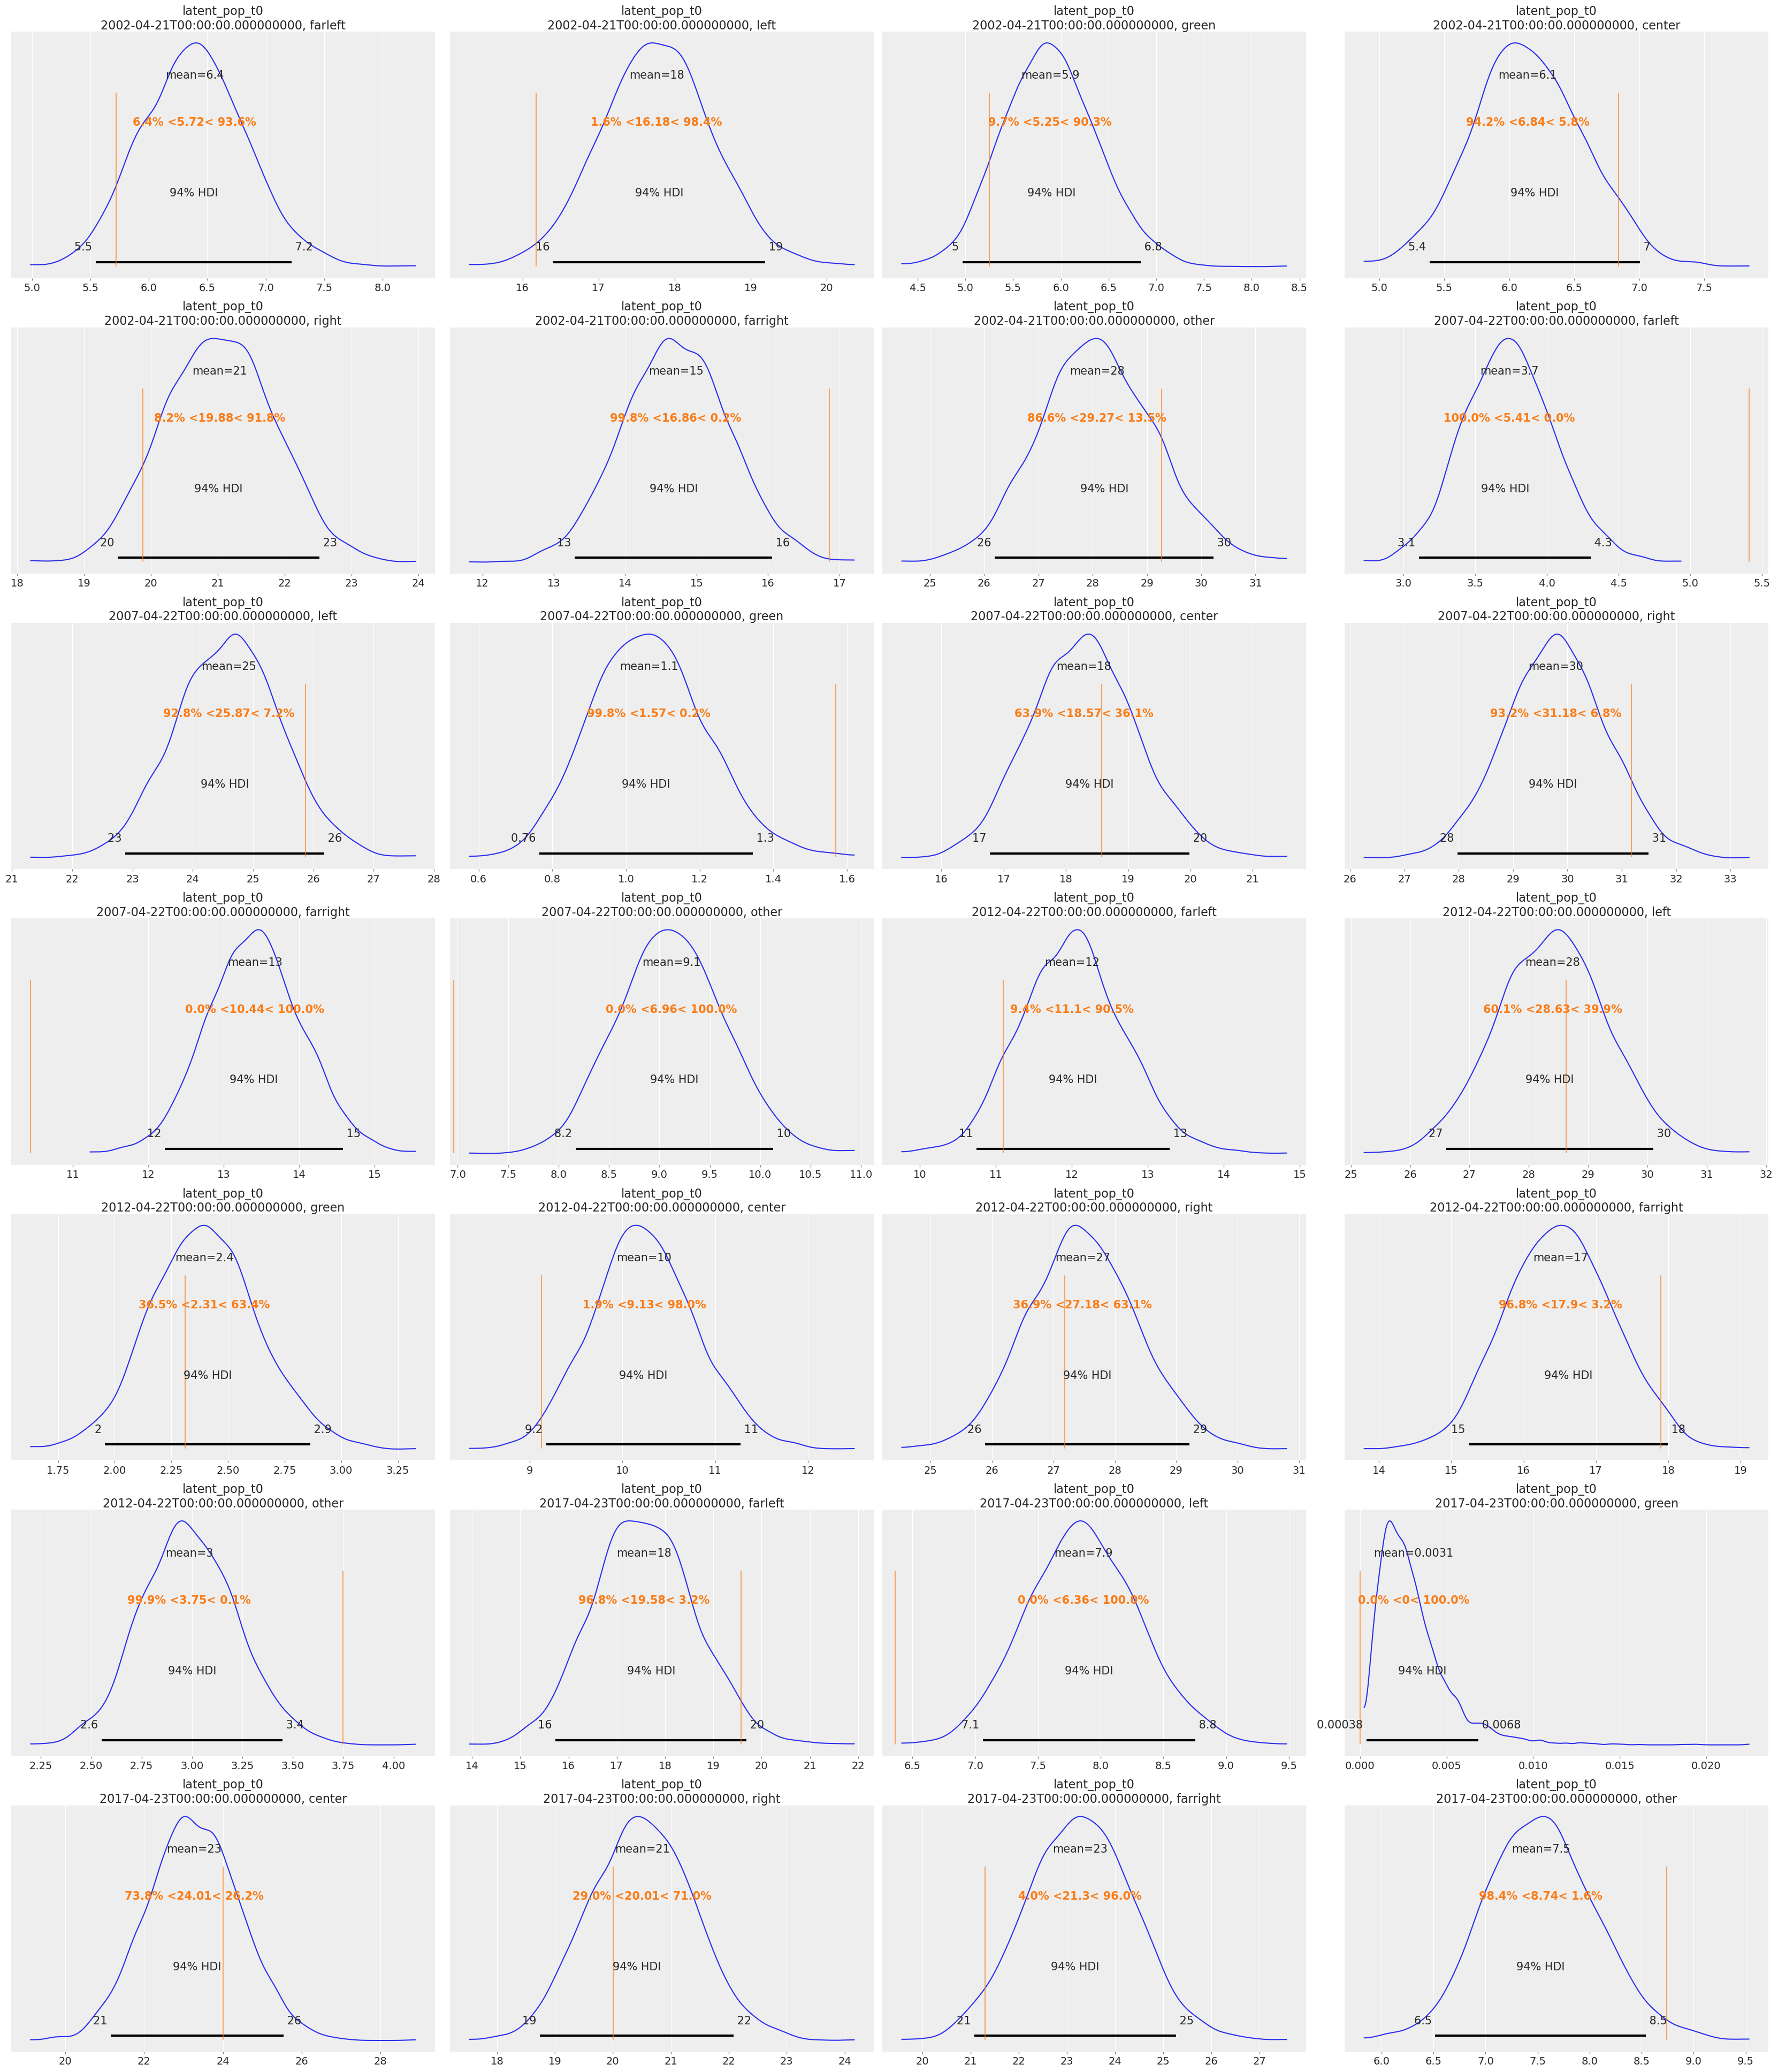

In [20]:
arviz.plot_posterior(
    election_forecast.predictions["latent_pop_t0"] * 100,
    ref_val=results[mb.political_families].to_numpy().flatten().tolist(),
);

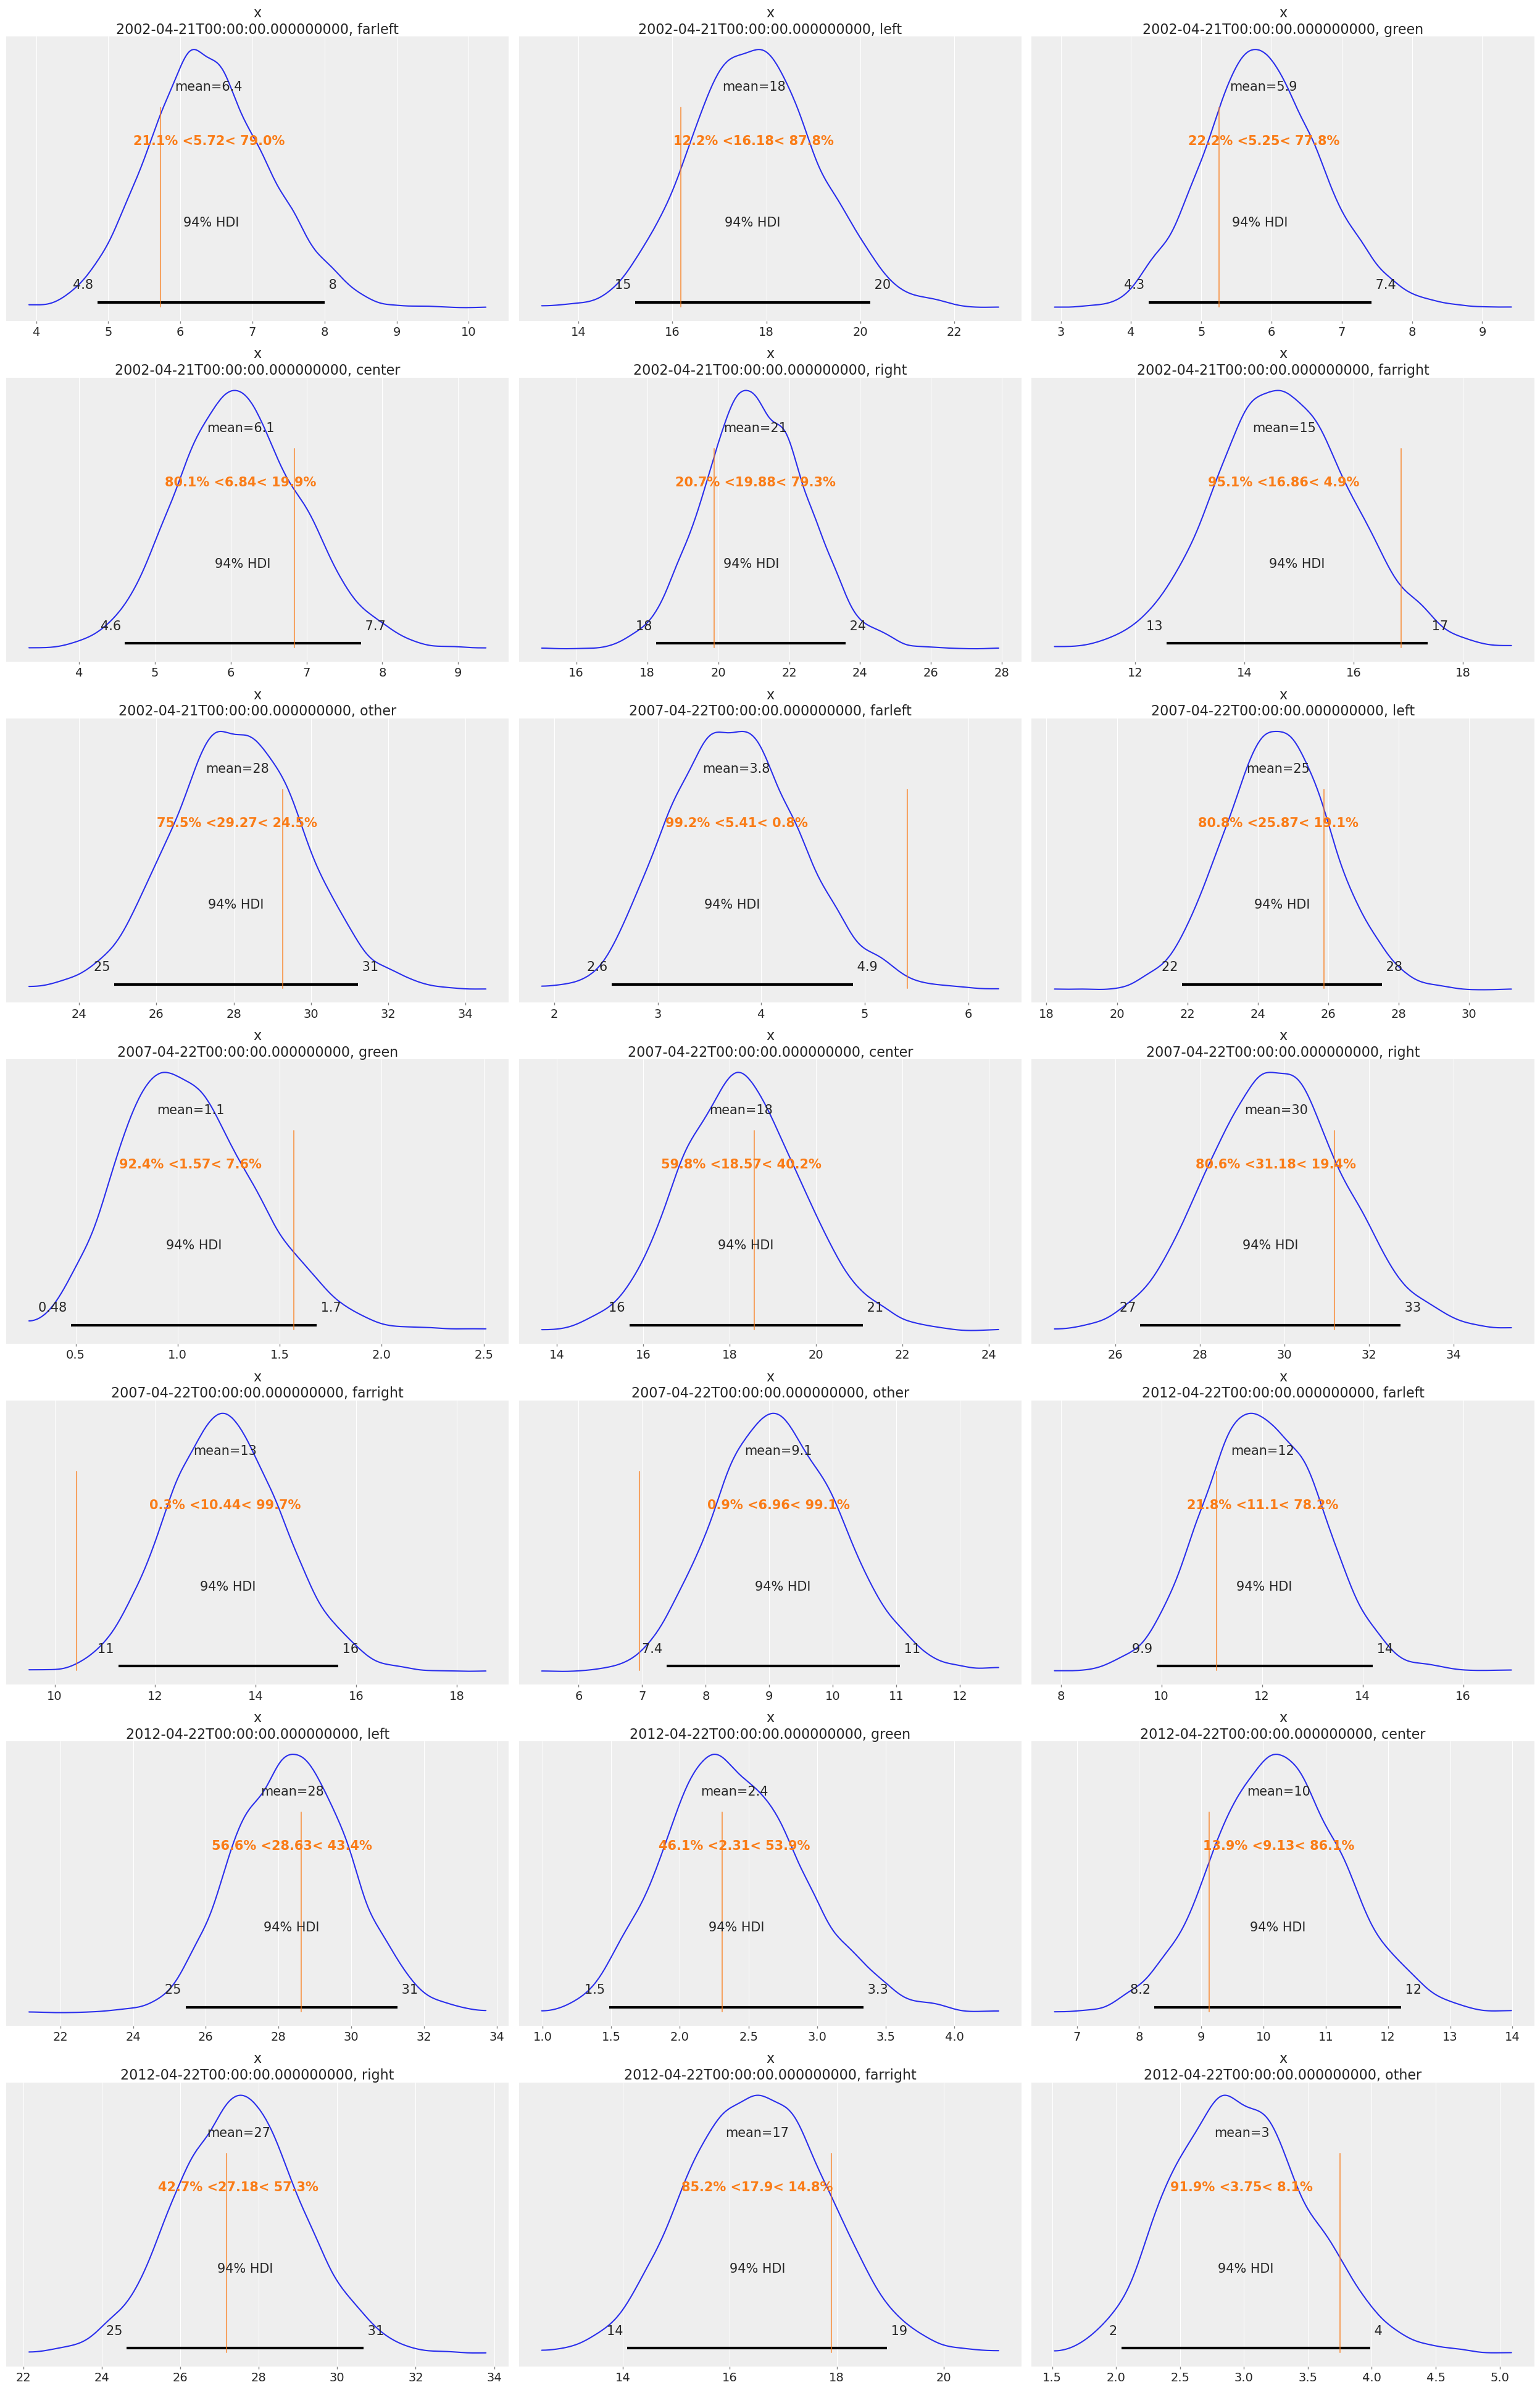

In [21]:
arviz.plot_posterior(
    (
        election_forecast.predictions["R"]
        / election_forecast.predictions_constant_data["results_N"]
    )
    * 100,
    ref_val=results[mb.political_families].to_numpy().flatten().tolist(),
);

In [26]:
# force green at 0
# covarying GP (transition matrix)

In [ ]:
# https://www.itl.nist.gov/div898/handbook/eda/section3/qqplot.htm
# add other election types (https://github.com/pollsposition/models/blob/master/district-level/munic_model_prod.ipynb)